In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from pprint import pprint
import pickle
import random
from bidict import bidict
import math
import statistics
from scipy.sparse import coo_matrix, csr_matrix, lil_matrix
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
%matplotlib inline
plt.style.use(['dark_background', 'ggplot'])
sns.set(color_codes=True)
sns.set_palette(sns.color_palette('pastel'))

# Data Set I/O

In [4]:
df = pd.read_pickle("/data/rali7/Tmp/solimanz/data/pickles/excerpt-2017-02-20_transformed.pkl")
#df.to_pickle("/data/rali7/Tmp/solimanz/data/pickles/excerpt-2017-02-20_transformed.pkl")

# Helper Functions

## Utilities

In [48]:
def to_percent(y, position):
    # The percent symbol needs escaping in latex
    if matplotlib.rcParams['text.usetex'] is True:
        return s + r'$\%$'
    else:
        return s + '%'

def fmtcols(mylist, cols):
    maxwidth = max(map(lambda x: len(x), mylist))
    justifyList = list(map(lambda x: x.ljust(maxwidth), mylist))
    lines = (' & '.join(justifyList[i:i+cols]) for i in range(0,len(justifyList),cols))
    return " \\\ \n".join(lines)

def get_ngrams(n, tokens):    
    return [tuple(tokens[i:i+n]) for i in range(len(tokens)-n+1)]

def print_latex_tables(cols, k=500):
    formatted = "\\begin{center}\n\\begin{tabular}{|l|l|l|l|}"
    formatted += fmtcols(function_freq.index[-k:], cols)
    formatted += "\n\\end{tabular}\n\\end{center}"
    with open(f"/data/rali7/Tmp/solimanz/data_viz/bottom_{k}.txt", "w") as f:
        f.write(formatted)
        
def clean(s):
    keywords = set(keywords)
    pttrn = re.compile(r"[^a-zA-Z\d\s]")
    r = re.sub(pttrn, " ", s)
    tokens = word_tokenize(s)
    return " ".join(filter(lambda t: t if t in keywords else '', tokens))

def compute_examples_n(ranks_counts, lower=100, upper=1500000, step=100):
    #top_ks = np.arange(10, 600000, 100)
    top_ks = np.arange(lower, upper, step)
    n_examples = []
    
    for k in top_ks:
        n_examples.append(rank_counts[:k].sum())
        
    return top_ks, n_examples

## Graphing Functions

In [ ]:
def unique_string_dist(func_freq):
    plt.rcParams['figure.figsize'] = 10, 3
    plt.rcParams['figure.dpi'] = 150

    ax = sns.countplot(func_freq.values, log=True)
    for ind, label in enumerate(ax.get_xticklabels()):
        if ind % 100 == 0:
            label.set_visible(True)
        else:
            label.set_visible(False)
        
    #ax = sns.distplot(function_freq.values, kde=False, rug=False, hist_kws={"log": True})
    ax.set_title("Distribution of Unique Job Title String Counts")
    t = ax.set_xlabel("String Counts")
    
def sting_lengths_boxplot(lengths, tokens=True):
    plt.rcParams['figure.figsize'] = 10, 3
    plt.rcParams['figure.dpi'] = 150
    ax = sns.boxplot(num_toks_title, orient='h')
    ax.set_title("Distribution of Job Title String Lengths")
    ax.set_xlabel("Number of Tokens")

def comparison_boxplots(dat, title="Distribution of Job Title String Lengths", x_label="", y_label="Number of Tokens"):
    plt.rcParams['figure.figsize'] = 15, 15
    plt.rcParams['figure.dpi'] = 150
    ax = sns.boxplot(x="range", y="length", data=dat, orient='v')
    ax.set_title(title)
    ax.set_ylabel(y_label)
    ax.set_xlabel(x_label)

# Initial Cleaning

In [18]:
df["transformed"] = df.function.str.lower()

In [19]:
# Remove URLs and/or emails from job titles
pattrn = re.compile(r"[\S]+\.(ca|com|org|fr|gov|net)")
df["transformed"] = df["transformed"].str.replace(pattrn, "")

# Replace .NET by dotnet to eliminate complications when removing periods
df["transformed"] = df["transformed"].str.replace(".net\b", "dotnet")

# Replace periods between word by a space
pattrn = re.compile(r"\.(?=[\w]{2})")
df["transformed"] = df["transformed"].str.replace(pattrn, " ")

# Replace periods in acronyms by empty string
df["transformed"] = df["transformed"].str.replace(".", "")

# Remove parens character
df["transformed"] = df["transformed"].str.replace(re.compile(r"\(.*\)"), "")

df["transformed"] = df["transformed"].str.replace(re.compile(r"co(?!\w)(\s)*-?(\s)*"), "co ")
df["transformed"] = df["transformed"].str.replace(re.compile(r"\bcofounder\b"), "co founder")
df["transformed"] = df["transformed"].str.replace(re.compile(r"\bcoowner\b"), "co owner")

#df["transformed"] = df["transformed"].str.replace(re.compile(r"co(?!\w)(\s)*-?(\s)*"), "co_")

## Regular Expressions

In [20]:
transforms = [    
    # senior/junior
    (re.compile(r'\bsr\b'), 'senior'),
    (re.compile(r'\bjr\b'), 'junior'),
    # IT
    (re.compile(r'\bit\b'), 'information technology'),
    # C*O
    (re.compile(r'\bceo\b'), 'chief executive officer'),
    (re.compile(r'\bcoo\b'), 'chief operating officer'),
    (re.compile(r'\bcto\b'), 'chief technology officer'),
    (re.compile(r'\bcfo\b'), 'chief finance officer'),
    (re.compile(r'\bchief financial officer\b'), 'chief finance officer'),
    (re.compile(r'\bchief operations officer\b'), 'chief operating officer'),
    # VP
    (re.compile(r'\bvp\b'), 'vice president'),
    (re.compile(r'\bvice-president\b'), 'vice president'),
    #technician vs tech
    (re.compile(r'\btech\b'), 'technician'),
    #coop
    (re.compile(r'\bco[-|\s]op\b'), 'coop'),
    #addon
    (re.compile(r'\badd[-|\s]on\b'), 'addon'),
    # Nurses
    (re.compile(r'\brn\b'), 'registered nurse'),
    (re.compile(r'\brpn\b'), 'registered practical nurse'),
    #T.A.
    (re.compile(r"\bta\b"), "teaching assistant"),
    (re.compile(r"\bteacher assistant\b"), "teaching assistant"),
    (re.compile(r"\bteacher's assistant\b"), "teaching assistant"),
    (re.compile(r"\bteacher's assitant\b"), "teaching assistant"),
    
    (re.compile(r"\bra\b"), "research assistant"),
    # HR
    (re.compile(r'\bhr\b'), 'human resources'),
    # Customer service reps
    (re.compile(r'\bcsr\b'), 'customer service representative'),
    # qa / qc
    (re.compile(r'\bqa\b'), 'quality assurance'),
    (re.compile(r'\bqc\b'), 'quality control'),
    # database administrator
    (re.compile(r'\bdba\b'), 'database administrator'),
    (re.compile(r'\bdatabase admin\b'), 'database administrator'),
    (re.compile(r'\bdb admin\b'), 'database administrator'),
    # financial service representative
    (re.compile(r'\bfsr\b'), 'financial service representative'),
    # Misspellings
    (re.compile(r'\bfreelance\b'), 'freelancer'),
    (re.compile(r'\bdesiginer\b'), 'designer'),
    (re.compile(r'\bbiomed\b'), 'biomedical'),
    (re.compile(r'\bgoverenment\b'), 'government'),
    (re.compile(r'\bmachanic\b'), 'mechanic'),
    (re.compile(r'\bbusiness owner\b'), 'owner'),
    (re.compile(r'\br(\s)*&(\s)*d\b'), 'research development'),
    (re.compile(r'\br and d\b'), 'research development'),
    (re.compile(r'research/development'), 'research development'),
    (re.compile(r'\beditor-in-chief\b'), 'editor_in_chief'),
    #eit => engineer in training
    (re.compile(r'\beit\b'), 'engineer in training'),
    #ESL
    (re.compile(r'\besl$'), 'english as a second language instructor'),
    (re.compile(r'\besl instructor\b'), 'english as a second language instructor'),
    (re.compile(r'\besl teacher\b'), 'english as a second language instructor'),
    (re.compile(r'\benglish as a second language^'), 'english as a second language instructor'),
    (re.compile(r'\benglish as a second language teacher\b'), 'english as a second language instructor'),
    (re.compile(r'\besl instructor\b'), 'english as a second language instructor'),
    
    (re.compile(r"\binternship\b"), "intern"),
    (re.compile(r"\bsummer intern\b"), "intern"),
    
    (re.compile(r"\bis\b"), "information systems"),
    (re.compile(r"\bgis\b"), "geographic information system"),
    (re.compile(r"\bpr\b"), "public relations"),
    (re.compile(r"\badmin\b"), "administrator"),
    (re.compile(r"\brep\b"), "representative")
]

substitutions = {r: rep for r, rep in transforms}

In [21]:
df['transformed'].replace(substitutions, regex=True, inplace=True)
df['transformed'].replace({re.compile(r"\s{2,}"): " "}, regex=True, inplace=True)
df["transformed"] = df["transformed"].str.strip()

In [22]:
df['transformed'].replace({re.compile(r"\bengineer engineer\b"): "engineer"}, regex=True, inplace=True)
df["transformed"] = df["transformed"].str.strip()

In [23]:
df['transformed'].replace({re.compile(r"\bs/w\b"): "software"}, regex=True, inplace=True)
df["transformed"] = df["transformed"].str.strip()

In [24]:
df['transformed'].replace({re.compile(r"\s+/\s+"): "/"}, regex=True, inplace=True)
df['transformed'].replace({re.compile(r"\bux/ui\b"): "ui ux"}, regex=True, inplace=True)
df['transformed'].replace({re.compile(r"\bui/ux\b"): "ui ux"}, regex=True, inplace=True)
df["transformed"] = df["transformed"].str.strip()

In [25]:
function_freq = df.transformed.value_counts(normalize=False)
french = [s for s in function_freq.index if 
          "directeur" in s or "é" in s or "à" in s or "è" in s or " et " in s or " de " in s]
french_ids = df[df.transformed.isin(french)]._id.unique()
len(french_ids)

53106

In [26]:
dropped = df.drop(df[df._id.isin(french_ids)].index)

In [28]:
pattrn = re.compile(r"[^a-zA-Z\d\s]")
titles = [set(word_tokenize(re.sub(pattrn, " ", t))) for t in function_freq.index]
zero_length = [i for i, tok in enumerate(titles) if len(tok) == 0]
one_length = [i for i, tok in enumerate(titles) if len(tok) == 1]
weird = [function_freq.index[i] for i in zero_length]

#with open("/data/rali7/Tmp/solimanz/data/na_funcs.pkl", "wb") as f:
#    pickle.dump(weird, f)

bad_ids = dropped[dropped.transformed.isin(weird)]._id.unique()
len(bad_ids)

3023

In [30]:
dropped = dropped.drop(dropped[dropped._id.isin(bad_ids)].index)

# Statistics

In [4]:
function_freq = df.transformed.value_counts(normalize=False)
n_ids = df._id.nunique()
print(f"Number of unique job titles: {len(function_freq)}\nNumber of user profiles: {n_ids}")

Number of unique job titles: 3830443
Number of user profiles: 2789691


In [173]:
with open("/data/rali7/Tmp/solimanz/data_viz/all_job_titles.txt", "w") as f:
    for title, value in zip(function_freq.index, function_freq.values):
        f.write(f"{title}\t{value}\n")

In [140]:
function_freq = df.transformed.value_counts(normalize=False)
n_ids = df._id.nunique()
print(f"Number of unique job titles: {len(function_freq)}\nNumber of user profiles: {n_ids}")

Number of unique job titles: 3830435
Number of user profiles: 2789685


In [16]:
cc = Counter(function_freq.values)
sum([x[1] for x in cc.most_common(10)])/len(function_freq)

0.981743858056547

In [17]:
print(f"Number of unique job titles used for last job: {df[df.job_index == 0].transformed.nunique()}")

Number of unique job titles used for last job: 927209


## Distribution of Unique Job Title String Counts

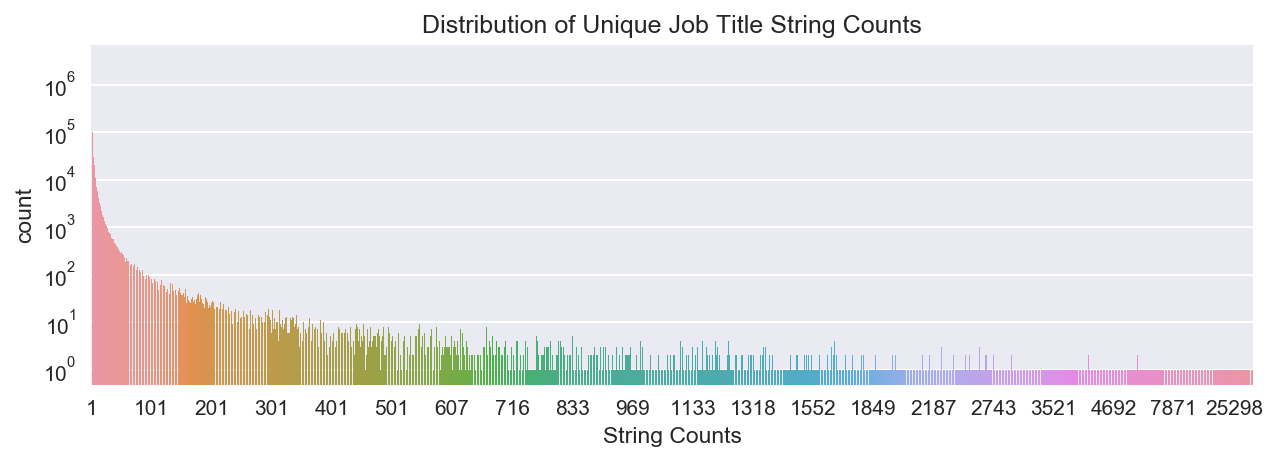

In [18]:
unique_string_dist(function_freq)

## Length of Job Histories

In [53]:
df.columns

Index(['_id', 'company_name', 'end_date', 'function', 'industry', 'job_index',
       'place', 'start_date', 'transformed'],
      dtype='object')

In [138]:
max_job_index = df.groupby("_id")["job_index"].max()
max_job_index = max_job_index.apply(lambda x: x + 1)
print(f"Average Length of job history: {max_job_index.mean()}")
print(f"Longest job history: {max_job_index.max()}")
print(f"Shortest job history: {max_job_index.min()}")

Average Length of job history: 5.177948406361292
Longest job history: 140
Shortest job history: 3


Text(0.5,0,'Number of Positions Held')

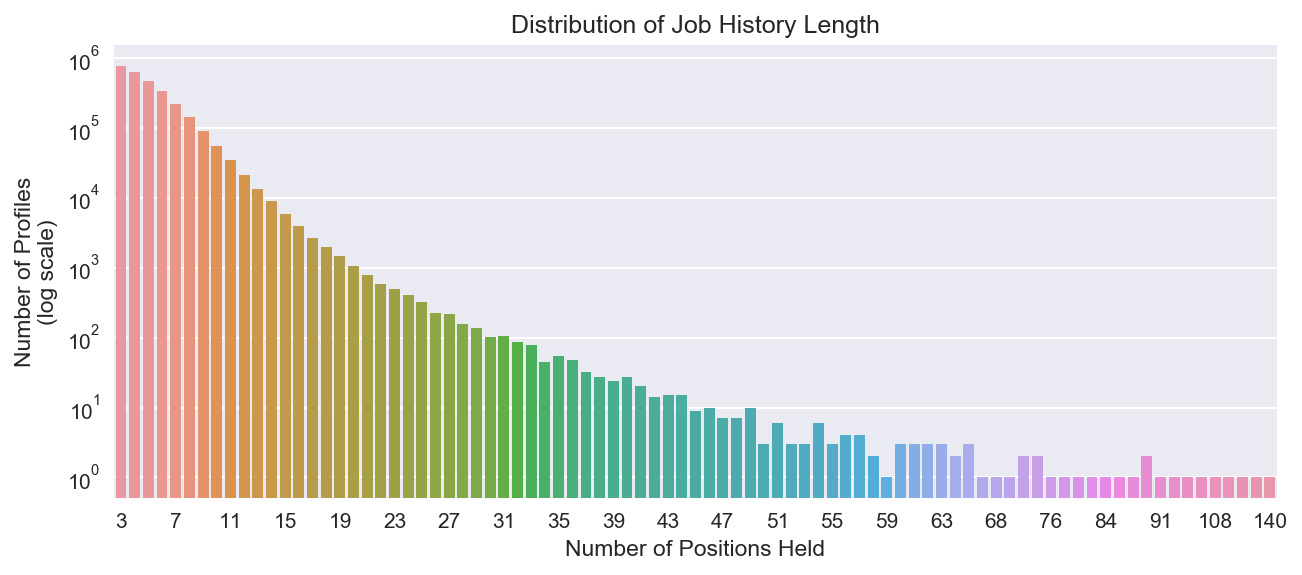

In [20]:
plt.rcParams['figure.figsize'] = 10, 4
plt.rcParams['figure.dpi'] = 150

ax = sns.countplot(max_job_index, log=True)
for ind, label in enumerate(ax.get_xticklabels()):
        if ind % 4 == 0:
            label.set_visible(True)
        else:
            label.set_visible(False)

ax.set_title("Distribution of Job History Length")
ax.set_ylabel("Number of Profiles\n(log scale)")
ax.set_xlabel("Number of Positions Held")

## Tokenize Job Title Strings

In [129]:
# Build vocabulary
pattrn = re.compile(r"[^a-z\d\s]")
joined = " ".join(function_freq.index.values)
joined = re.sub(pattrn, " ", joined)
tokens = word_tokenize(joined)
to_remove = set(stopwords.words('english'))
tokens = list(filter(lambda s: s not in to_remove, tokens))
unigram_counts = Counter(tokens)
tokens = bidict({word: key for key, word in enumerate(unigram_counts.keys())})

In [6]:
pattrn = re.compile(r"[^a-z\d\s]")
funcs = [re.sub(pattrn, " ", s) for s in function_freq.index]

In [115]:
pattrn = re.compile(r"[^a-z\d\s]")
tokenized_titles = [(title, word_tokenize(re.sub(pattrn, " ", title))) for title in function_freq.index]

In [7]:
tfidf_vect = TfidfVectorizer(tokenizer=word_tokenize, stop_words=stopwords.words('english'))

In [8]:
_ = tfidf_vect.fit(funcs)

In [9]:
threshold = 10000
upper_funcs = funcs[:threshold]
lower_funcs = funcs[threshold:]

In [10]:
dat = tfidf_vect.transform(upper_funcs)
Y = tfidf_vect.transform(lower_funcs)

In [11]:
cosine = cosine_similarity(Y, dat,  dense_output=False)

In [13]:
type(cosine)

scipy.sparse.csr.csr_matrix

In [15]:
with open("/data/rali7/Tmp/solimanz/data/pickles/cosine.pkl", "wb") as f:
    pickle.dump(file=f, obj=cosine)

MemoryError: 

In [ ]:
mapping_ids = cosine.argmax(axis=1)

In [ ]:
mapping_ids = mapping_ids.getA1()

In [ ]:
with open("/data/rali7/Tmp/solimanz/data/pickles/mappings.pkl", "wb") as f:
    pickle.dump(file=f, obj=mappings)

In [ ]:
title_mapping = {lower_funcs[original]: upper_funcs[new_title] for original, new_title in enumerate(maps)}

In [ ]:
title_mapping

In [23]:
num_toks_title = {toks[0]: len(toks[1]) for toks in tokenized_titles}

In [25]:
sum(num_toks_title.values())/len(num_toks_title)

4.487992795884784

In [28]:
max(num_toks_title.values())

42

In [29]:
freqs = [function_freq[t] for t in function_freq.index]
n_tokens = [num_toks_title[t] for t in function_freq.index]

Text(0.5,0,'Number of Tokens')

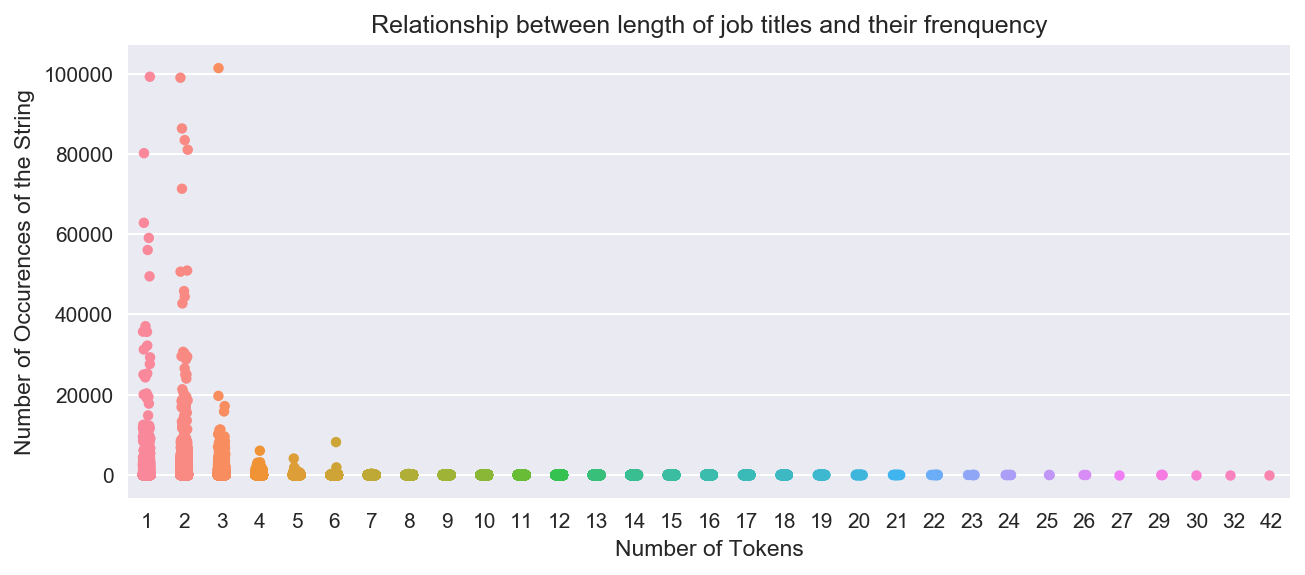

In [30]:
ax = sns.stripplot(x=n_tokens, y=freqs, jitter=True)
ax.set_title("Relationship between length of job titles and their frenquency")
ax.set_ylabel("Number of Occurences of the String")
ax.set_xlabel("Number of Tokens")

In [31]:
matches = [title for title in function_freq.index if function_freq[title] <= 10 and num_toks_title[title] <=5]

In [ ]:
ranges = {}
ranges["10^4"] = function_freq[function_freq >= 10000]
ranges["10^3"] = function_freq[(function_freq < 10000) & (function_freq >= 1000)]
ranges["10^2"] = function_freq[(function_freq < 1000) & (function_freq >= 100)]
ranges["10^1"] = function_freq[(function_freq < 100) & (function_freq >= 10)]
ranges["10^0"] = function_freq[(function_freq < 10) & (function_freq >= 1)]

In [ ]:
pattrn = re.compile(r"[^a-zA-Z\d\s]")
to_remove = set(stopwords.words('english'))

dat = {"range": [], "length": []}
for key, series in ranges.items():
    for job_title in series.index.values:
        dat["range"].append(key)
        s = re.sub(pattrn, " ", job_title)
        toks = word_tokenize(s)
        toks = list(filter(lambda s: s not in to_remove, toks))
        dat["length"].append(len(toks))
dat = pd.DataFrame(dat)

In [ ]:
unigrams = sorted(unigram_counts.keys(), key=lambda k: unigram_counts[k], reverse=True)
avgs = []
top_ks = np.arange(10, len(unigrams), 100)

for k in top_ks:
    to_keep = set(unigrams[:k])
    n_tokens = np.zeros(len(function_freq), dtype=np.int32)
    
    for i, title in enumerate(titles):
        n_tokens[i] = len(title.intersection(to_keep))
    
    avgs.append(np.average(n_tokens))

In [ ]:
with open("/data/rali7/Tmp/solimanz/data/top_ks.pkl", "wb") as f:
    pickle.dump(file=f, obj=top_ks)
with open("/data/rali7/Tmp/solimanz/data/avgs.pkl", "wb") as f:
    pickle.dump(file=f, obj=avgs)

In [ ]:
with open("/data/rali7/Tmp/solimanz/data/top_ks.pkl", "rb") as f:
    top_ks = pickle.load(file=f)
with open("/data/rali7/Tmp/solimanz/data/avgs.pkl", "rb") as f:
    avgs = pickle.load(file=f)

In [ ]:
plt.rcParams['figure.figsize'] = 10, 3
plt.rcParams['figure.dpi'] = 100

plt.plot(top_ks, avgs)
plt.title("Effect of keeping only top K most used unigrams to filter job title strings")
plt.xlabel("Top K most used tokens to consider")
plt.ylabel("Avg. # of tokens (length)")

In [ ]:
bigrams = get_ngrams(2, tokens)
trigrams = get_ngrams(3, tokens)
fourgrams = get_ngrams(4, tokens)
fivegrams = get_ngrams(5, tokens)

In [ ]:
unigram_counts = Counter(tokens)
bigrams_counts = Counter(bigrams)
trigrams_counts = Counter(trigrams)
fourgrams_counts = Counter(fourgrams)
fivegrams_counts = Counter(fivegrams)

In [ ]:
counts = list(filter(lambda x: x > 0, token_counts.values()))

In [ ]:
avg = sum(counts)/len(counts)

In [ ]:
keywords = list(filter(lambda x: token_counts[x] > avg, token_counts.keys()))

In [ ]:
plt.rcParams['figure.figsize'] = 15, 7
plt.rcParams['figure.dpi'] = 100

ax = sns.distplot(counts, kde=False, rug=False, hist_kws={"log": True})
ax.set_title("Distribution of Unique Token Counts")
ax.set_xlabel("Token Counts")

In [ ]:
n_tokens = len(token_counts.keys())
n_titles = len(function_freq)
print(f"Number of Unique Tokens: {n_tokens}\nNumber of Unique Job Title Stings: {n_titles}")

In [ ]:
count_mapping = defaultdict(list)
for tok, count in token_counts.items():
        count_mapping[count].append(tok)

In [ ]:
count_ntok = sorted([(k, len(v)) for k, v in count_mapping.items()], key=lambda i: i[0] )

In [ ]:
counts = [x[0] for x in count_ntok]
num_tok = [x[1] for x in count_ntok]

In [ ]:
avg_title_len = sum([len(s) for s in function_freq.index.values])/len(function_freq)

In [ ]:
print(f"Average title length: {avg_title_len}")
print(f"Maximum length: {max(title_lenghts)}")

In [ ]:
keywords = [t[0] for t in unigram_counts.most_common(1810)]

# Reduction

In [15]:
matches = [s for s in function_freq.index if ' - ' in s]

In [16]:
matches

['director - business development',
 'vice president - operations',
 'owner - operator',
 'vice president - finance',
 'project manager - contract',
 'regional sales manager - western canada',
 'vice president - business development',
 'manager - business development',
 'vice president - sales',
 'software developer - intern',
 'director of sales - canada',
 'regional sales manager - canada',
 'software developer - coop',
 'national sales manager - canada',
 'general manager - canada',
 'consultant - project manager',
 'director - board of directors',
 'project manager - consultant',
 'manager - operations',
 'sales manager - canada',
 'manager - human resources',
 'vice president - sales & marketing',
 'president - owner',
 'owner - president',
 'programmer - analyst',
 'country manager - canada',
 'member - board of directors',
 'vice president - marketing',
 'regional manager - western canada',
 'vice president - sales and marketing',
 'administrative assistant - human resources',
 

In [89]:
re.sub(r"\bs/w\b", "software", "s/w engineer")

'software engineer'

In [78]:
pattrn = re.compile(r"[\\/,.\|&]|(\s+-\s+)|\band\b|\bat\b")

In [80]:
re.split(pattrn, "asdf at sdf")

['asdf ', None, ' sdf']

In [155]:
replace = []
#pattrn = re.compile(r"[^a-z0-9-\+#'_\s&]")
pattrn = re.compile(r"[\\/,.\|&]|(\s+-\s+)|\band\b|\bat\b")

#pattrn = re.compile(r"[\\/,.&]|(\s+-\s+)|\band\b")

for title in function_freq.index:
    if re.search(pattrn, title):
        replace.append(title)

In [156]:
pattrn = re.compile(r"[\\/,.\|&]|(\s+-\s+)|\band\b|\bat\b")
mapping = lambda s: sorted([x.strip() for x in re.split(pattrn, s) if x], 
                           key=lambda x: function_freq[x] if x in function_freq else -1 , 
                           reverse=True)

In [157]:
a = list(map(mapping, replace))

In [59]:
print(f"{len(replace)}")
print(f"{len(a)}")

1811396
1811396


In [158]:
notin = [s for s in a if s[0] not in function_freq]

In [148]:
notin

[('student-at-law', ['student-', '-law']),
 ('eh&s advisor', ['eh', 's advisor']),
 ('strength and conditioning intern', ['strength', 'conditioning intern']),
 ('eh&s coordinator', ['eh', 's coordinator']),
 ('assistant f&b manager', ['assistant f', 'b manager']),
 ('summer student-at-law', ['summer student-', '-law']),
 ('stay-at-home mom', ['stay-', '-home mom']),
 ('member-at-large', ['member-', '-large']),
 ('advisory i/t specialist', ['advisory i', 't specialist']),
 ('oh&s coordinator', ['oh', 's coordinator']),
 ('stay at home mother', ['stay', 'home mother']),
 ('oh&s consultant', ['oh', 's consultant']),
 ('u/g miner', ['u', 'g miner']),
 ('independent writing and editing professional',
  ['independent writing', 'editing professional']),
 ('estate and trust advisor', ['estate', 'trust advisor']),
 ('maritime surface and sub-surface officer',
  ['maritime surface', 'sub-surface officer']),
 ('eh&s specialist', ['eh', 's specialist']),
 ('glace bay, ns', ['glace bay', 'ns']),
 (

In [38]:
len(notin)/len(a)

0.048201497629452646

In [62]:
len(notin)/len(a)

0.03867072688688724

In [159]:
len(notin)/len(a)

0.048764915751098085

In [86]:
increase = [function_freq[s[1]] - function_freq[s[0]] for s in a if s[0] in function_freq and s[1] in function_freq]
sum([i > 0 for i in increase])/len(a)

0.8421439514351956

In [9]:
# Take String that comes before a comma,or '/''
#pattrn = re.compile(r"[^a-z0-9-\+#'_\s]|\band\b")
#pattrn = re.compile(r"[\\/,.&]|(\s+-\s+)|\band\b")

In [160]:
pattrn = re.compile(r"[\\/,.\|&]|(\s+-\s+)|\band\b|\bat\b")

mapping = lambda s: sorted([x.strip() for x in re.split(pattrn, s) if x], 
                           key=lambda x: function_freq[x] if x in function_freq else -1 , 
                           reverse=True)[0]
df["reduced"] = df.transformed.apply(mapping).str.strip()

In [185]:
reduced_freq = df.reduced.value_counts(normalize=False)
print(f"Number of reduced unique job titles: {len(reduced_freq)}")

Number of reduced unique job titles: 1511251


In [172]:
with open("/data/rali7/Tmp/solimanz/data_viz/reduced_job_title.txt", "w") as f:
    for title, value in zip(reduced_freq.index, reduced_freq.values):
        f.write(f"{title}\t{value}\n")

In [49]:
all_ids = df._id.nunique()
bad_ids = df[~df.reduced.isin(reduced_freq.index[:20000])]._id.nunique()
all_ids - bad_ids

1023912

In [56]:
lengths = [len(s) for s in reduced_freq.index[:9000]]

In [62]:
print(statistics.mean(lengths))
print(statistics.median(lengths))
print(statistics.variance(lengths))
print(statistics.stdev(lengths))

18.384777777777778
18.0
49.83248300428443
7.0592126334517245


In [61]:
bad_ids = df[df.reduced == '']._id.unique()
len(bad_ids)

22468

In [62]:
dat = df.drop(df[df._id.isin(bad_ids)].index)

In [63]:
reduced_freq = dat.reduced.value_counts()

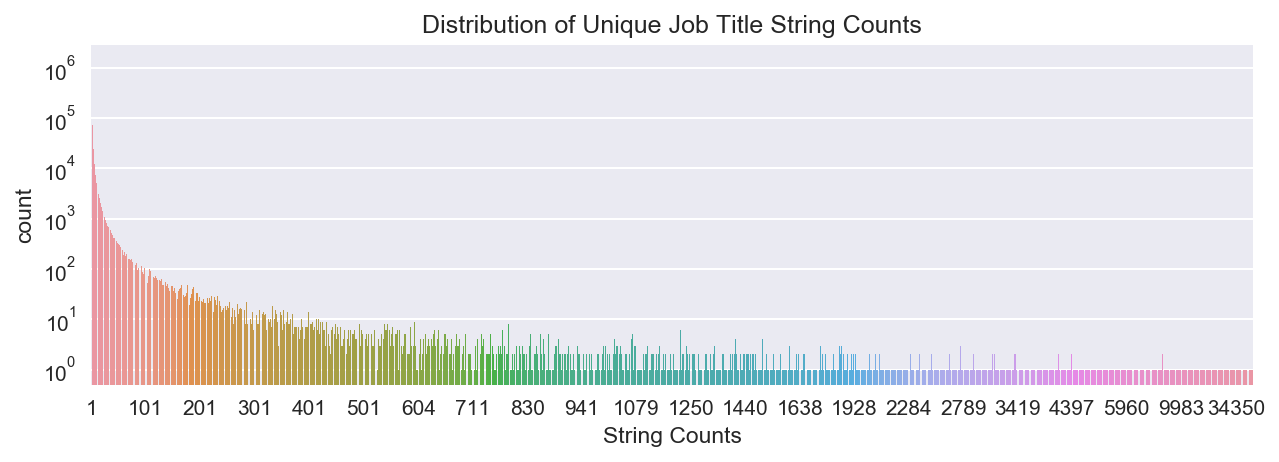

In [196]:
unique_string_dist(reduced_freq)

In [163]:
df["title_rank"] = df.reduced.apply(lambda s: reduced_freq.index.get_loc(s))
id_ranks = df.groupby("_id")["title_rank"].max()
rank_counts = id_ranks.value_counts().sort_index()
x, y = compute_examples_n(rank_counts, lower=100, upper=1000000)

In [165]:
#ratios = [n_titles/n_ex for n_titles, n_ex in zip(top_ks, n_examples)]
x_gains = x[1:]
gains = [(100*(b - a))/a for a, b in zip(y[:-1], y[1:])]

Text(0,0.5,'Gain of training examples')

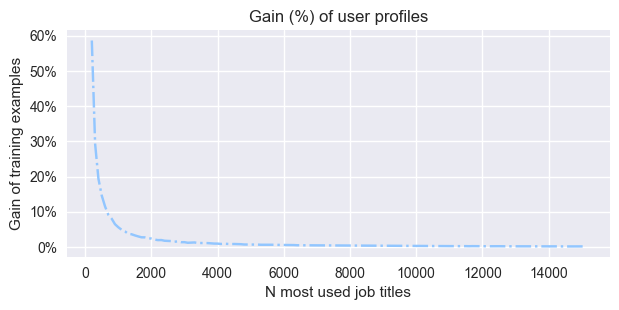

In [166]:
plt.rcParams['figure.figsize'] = 7, 3
plt.rcParams['figure.dpi'] = 100

plt.plot(x_gains[:150], gains[:150], '-.', alpha=1)
plt.gca().set_yticklabels(['{:.0f}%'.format(x) for x in plt.gca().get_yticks()]) 
plt.title("Gain (%) of user profiles")
plt.xlabel("N most used job titles")
plt.ylabel("Gain of training examples")

In [169]:
all_ids = df._id.nunique()
bad_ids = df[~df.reduced.isin(reduced_freq.index[:7000])]._id.nunique()
all_ids - bad_ids

837927

In [170]:
max_job_index = df.groupby("_id")["job_index"].max()
max_job_index = max_job_index.apply(lambda x: x + 1)
print(f"Average Length of job history: {max_job_index.mean()}")
print(f"Longest job history: {max_job_index.max()}")
print(f"Shortest job history: {max_job_index.min()}")

Average Length of job history: 5.177948406361292
Longest job history: 140
Shortest job history: 3


In [78]:
max_job_index[max_job_index==1]

_id
52e7df060b0451fc328b9d90    1
55e5f9510b0451e65f8e789e    1
55e6ea5d0b04514a0b8f0c34    1
55e814fd0b04517f1d8cba15    1
55e9dbc40b0451ab2d8e8b4c    1
55ea4a6e0b0451ab2d954244    1
55ed13790b0451ab2db74098    1
55ef5dc40b0451c87b934fcc    1
5792a43d9d15a9ba588bd1af    1
Name: job_index, dtype: int64

In [79]:
df[df._id == "52e7df060b0451fc328b9d90"]

,_id,company_name,end_date,function,industry,job_index,place,start_date,transformed,reduced
2101938,52e7df060b0451fc328b9d90,Bank of Montreal,NaN,Underwriter/Credit Specialist,Financial Services,0,NaN,2002-06,underwriter/credit specialist,underwriter


In [171]:
df.to_pickle("/data/rali7/Tmp/solimanz/data/pickles/excerpt-2017-02-20_reduced.pkl")

In [175]:
df[df._id == '576578169d15a95a668b6147']

,_id,company_name,end_date,function,industry,job_index,place,start_date,transformed,reduced,title_rank
14190897,576578169d15a95a668b6147,Artifact Nouveau,2016-04,Illustrator,Arts and Crafts,0,NaN,2016-04,illustrator,illustrator,695
14190898,576578169d15a95a668b6147,Jersey Devil Press,2016-04,Illustrator,Arts and Crafts,1,NaN,2016-04,illustrator,illustrator,695
14190899,576578169d15a95a668b6147,The Critical Pass Review,2016-04,Artist,Arts and Crafts,2,NaN,2016-04,artist,artist,261
14190900,576578169d15a95a668b6147,Riding Light Review,2016-04,Artist,Arts and Crafts,3,NaN,2016-04,artist,artist,261
14190901,576578169d15a95a668b6147,Balloons Lit Journal,2016-03,Artist,Arts and Crafts,4,NaN,2016-03,artist,artist,261
14190902,576578169d15a95a668b6147,Santa Clara Review,2016-03,Illustrator,Arts and Crafts,5,NaN,2016-03,illustrator,illustrator,695
14190903,576578169d15a95a668b6147,GTK Creative Journal,2016-03,Artist,Arts and Crafts,6,"Cleveland/Akron, Ohio Area",2016-03,artist,artist,261
14190904,576578169d15a95a668b6147,Finishing Line Press,2016-02,Artist,Arts and Crafts,7,NaN,2016-02,artist,artist,261
14190905,576578169d15a95a668b6147,Canyon Voices Literary Magazine,2016-02,Artist,Arts and Crafts,8,NaN,2016-02,artist,artist,261
14190906,576578169d15a95a668b6147,The Lost Coast Review,2016-02,Cartoonist,Arts and Crafts,9,NaN,2016-02,cartoonist,cartoonist,9386


In [187]:
len(function_freq[function_freq >= 100])

9651

In [189]:
top = function_freq[:550].index

In [190]:
bad_ids = df[~df.transformed.isin(top)]._id.unique()

In [191]:
all_ids = df._id.unique()

In [192]:
len(all_ids) - len(bad_ids)

120401

In [193]:
top = reduced_freq[:550].index
bad_ids = df[~df.reduced.isin(top)]._id.unique()
all_ids = df._id.unique()
len(all_ids) - len(bad_ids)

266192

In [188]:
len(reduced_freq[reduced_freq >= 100])

10424

In [10]:
funcs = df['function'].str.lower()

In [12]:
funcs = funcs.value_counts()

In [23]:
funcs['english as a second language']

13

In [28]:
funcs_norm = df['function'].str.lower().value_counts(normalize=True)

Text(0,0.5,'Frequency')

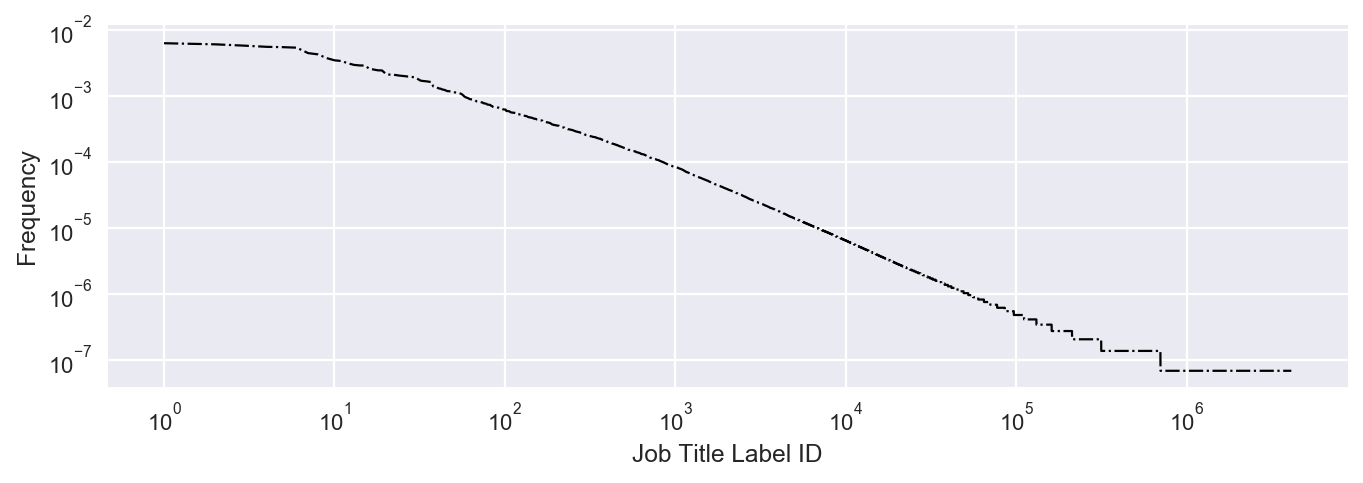

In [38]:
plt.rcParams['figure.dpi'] = 160
plt.rcParams['figure.figsize'] = (10,3)
plt.rcParams['lines.linewidth'] = 1

plt.loglog(sorted(funcs_norm.values, reverse=True), '-.', color='black')
plt.xlabel('Job Title Label ID')
plt.ylabel('Frequency')

In [36]:
len(funcs_norm)

4114289

In [37]:
df._id.nunique()

2789685